In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Vm during movement and rest episodes

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples[samples["SID"] == "W4_C4"].iloc[0]

vm = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/vm/filter.pkl")
vm_data = vm.get_data()

action_potentials = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/action_potentials.csv")
movement = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/movement_episodes.csv")
rest = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/rest_episodes.csv")

## Average Vm during movement

In [3]:
episode_vm_data = []

for i, episode in movement.iterrows():
    start = episode["EventStart"]
    end = episode["EventEnd"]
    channel = episode["Channel"]

    signal = vm_data[channel, start:end]

    episode_vm_data.append(signal)

continuous_vm_data = np.concatenate(episode_vm_data)

In [4]:
np.mean(continuous_vm_data)

-41.07017808048996

In [5]:
np.std(continuous_vm_data)

7.299413955759039

## Average Vm during movement, excluding AP episodes

In [6]:
episode_vm_data_no_ap = []

for i, episode in movement.iterrows():
    start = episode["EventStart"]
    end = episode["EventEnd"]
    channel = episode["Channel"]

    signal_range = np.arange(start, end)

    channel_aps = action_potentials[action_potentials["Channel"] == channel]
    episode_aps = np.logical_and(
        channel_aps["EventStart"] >= start,
        channel_aps["EventStart"] <= end
    )

    if sum(episode_aps) >= 1:
        # Get APs within the episode and remove their ranges
        episode_aps = channel_aps[episode_aps]
        for j, ap in episode_aps.iterrows():
            ap_start = round(ap["EventStart"])
            ap_end = round(ap["EventEnd"]) + 50

            ap_range = np.arange(ap_start, ap_end)
            signal_range = [i for i in signal_range if i not in ap_range]

    signal = vm_data[channel, signal_range]

    episode_vm_data_no_ap.append(signal)

continuous_vm_data_no_ap = np.concatenate(episode_vm_data_no_ap)

In [7]:
np.mean(continuous_vm_data_no_ap)

-41.493590013997874

In [8]:
np.std(continuous_vm_data_no_ap)

6.664067713524728

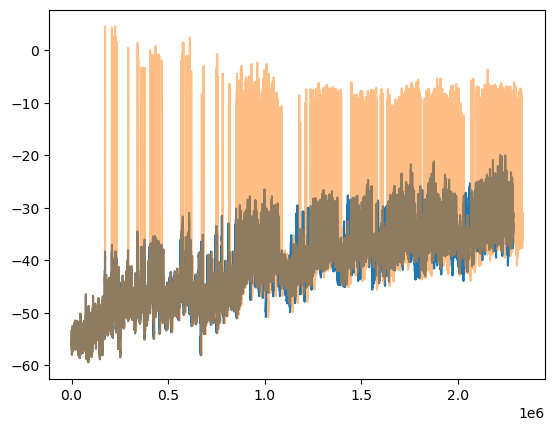

In [9]:
plt.plot(continuous_vm_data_no_ap)
plt.plot(continuous_vm_data, alpha = 0.5)
plt.show()

In [10]:
pd.DataFrame({
    "Mean": [np.mean(continuous_vm_data)],
    "MeanNoAP": [np.mean(continuous_vm_data_no_ap)],
    "SD": [np.std(continuous_vm_data)],
    "SDNoAP": [np.std(continuous_vm_data_no_ap)]
})

,Mean,MeanNoAP,SD,SDNoAP
0,-41.070178,-41.49359,7.299414,6.664068
